In [14]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import datetime as dt

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.tree           import DecisionTreeClassifier
from sklearn.metrics        import accuracy_score, confusion_matrix
from scipy.stats.stats      import pearsonr
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble       import AdaBoostClassifier


In [15]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
#Import data files
campaigns = pd.read_csv('../data/campaigns.csv',header=0,sep=';')
donors = pd.read_csv('../data/donors.csv',header=0,sep=',',index_col=0)
gifts = pd.read_csv('../data/gifts.csv',header=0,sep=',',index_col=0)
donor_6169 = pd.read_csv('../data/selection campaign 6169.csv')
donor_7244 = pd.read_csv('../data/selection campaign 7244.csv')

donor_scoring = pd.read_csv('../data/new_campaign_selection.csv')

In [18]:
#Global Values
campaignid_train = 6169
campaignid_test = 7244

# <b> Create BaseTable </b>

## Data Cleaning

### Campaign Table

In [19]:
#Clean table
campaigns['lettersSent'] = campaigns['lettersSent'].astype(str).str.replace('\u202f','').astype(int)
campaigns['CostUnit'] = campaigns['CostUnit'].astype(str).str.replace('\xa0€','').str.replace(',','.').astype(float)
campaigns['date'] = pd.to_datetime(campaigns['date'])
campaigns = campaigns.rename(columns={'date':'campaign_date'})
campaigns

,campaignID,campaign_date,lettersSent,CostUnit
0,153,2004-12-13,6873,0.17
1,154,2005-01-01,7656,0.30
2,180,2005-01-18,9933,0.20
3,433,2005-01-29,7448,0.59
4,476,2005-12-02,6605,0.51
...,...,...,...,...
362,7494,2019-10-17,8539,0.14
363,7503,2019-10-29,6126,0.15
364,7505,2019-11-16,29746,0.12
365,7519,2019-11-26,35199,0.36


### Donors Table

In [20]:
#Donor table cleaning
#Make province as UPPER to remove duplicate 
donors.province = donors.province.str.upper()

#Create Dummies for Province, Region and Language
donors = donors.join(pd.get_dummies(donors.province, drop_first = False))
donors = donors.join(pd.get_dummies(donors.region,prefix='Region_', drop_first = False))
donors = donors.join(pd.get_dummies(donors.language, drop_first = False))

#Encode Gender
donors.gender = donors.gender.fillna('M')
donors.gender = donors.gender.map({'M':0,'F':1})

#Convert birthdate to date
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])


In [21]:
donors_merge = donors

### Gifts Table

In [22]:
#creating a dummy variable for missing campaign ID (donations outside of campaigns)
gifts['campaignID_NA'] = 0
gifts.loc[gifts['campaignID'].isna(), 'campaignID_NA'] = 1

#converting to date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

#converting amount to integer (was obj)
gifts['amount'] = gifts['amount'].str.replace(',','.').astype(float)

#filling NA values with 0 in Campaign ID
gifts['campaignID']= gifts['campaignID'].fillna(0)
gifts['campaignID'] = gifts['campaignID'].astype(int)
gifts['month'] = gifts['date'].dt.month
gifts = pd.merge(gifts,gifts.groupby('donorID')['date'].agg('min').reset_index().rename(columns={'date':'min_date'}),how='left',on='donorID')

#Subset for Train and test data
gifts_train = gifts[(gifts['date'] > '2014-08-04') & (gifts['date'] <= '2018-08-04')]
gifts_test = gifts[(gifts['date'] > '2015-05-18') & (gifts['date'] <= '2019-05-18')]
gifts_new = gifts[(gifts['date'] > '2016-01-01') & (gifts['date'] <= '2020-01-01')]

In [24]:
#Function to calculate donated sum monthly
def monthwise(dataset: pd.DataFrame):
    gifts_month = dataset.groupby(['donorID','month'])['amount'].agg(['sum'])
    gifts_month = pd.DataFrame(gifts_month)
    gifts_month = gifts_month.reset_index()
    gifts_month = pd.pivot_table(gifts_month,columns=['month'],index='donorID')
    for col in gifts_month.columns:
        gifts_month = gifts_month.rename(columns={col[1]:col[0]+ '_' + str(col[1])})
    gifts_month = gifts_month['sum']
    #gifts_train = gifts_train.drop(columns='month')
    dataset = pd.merge(dataset,gifts_month,how='left',on='donorID')
    dataset = dataset.drop_duplicates(subset='donorID')
    return dataset

#Call function
gifts_train = monthwise(gifts_train)
gifts_test = monthwise(gifts_test)
gifts_new = monthwise(gifts_new)

In [25]:
#Function to calculate additional variables
def createVariables (maindata: pd.DataFrame,dataSet: pd.DataFrame,date: dt):
     #Calculate No of campaigns
    ## Train
    gifts_campaigns =  dataSet.groupby('donorID')['campaignID'].agg('count')
    gifts_campaigns = gifts_campaigns.reset_index()
    gifts_campaigns = gifts_campaigns.rename(columns={'campaignID':'No_campaigns'})

    #Calculate variables from amount
    ## Train
    gifts_amount = dataSet.groupby('donorID')['amount'].agg(['sum','mean','max','min'])
    gifts_amount = gifts_amount.reset_index()
    gifts_amount = gifts_amount.rename(columns={'sum':'Total_Amount','mean':'Average_Amount','max':'Maximum_Amount','min':'Minimum_Amount'})

    #Select Max date
    gifts_recency = dataSet[dataSet.groupby('donorID').date.transform('max') == dataSet['date']]
    gifts_recency = gifts_recency[['donorID', 'date']]
    gifts_recency = gifts_recency.rename(columns={"date": "max_date"})
    gifts_recency['recency'] = pd.to_datetime(date) - gifts_recency['max_date']
    gifts_recency['recency'] = gifts_recency['recency'].astype(str).str[:-5].astype(int)

    #Merge the variables
    ## Train
    return_dataset = pd.merge(dataSet,gifts_campaigns,how='left',on='donorID')
    return_dataset = pd.merge(return_dataset,gifts_amount,how='left',on='donorID')
    return_dataset = pd.merge(return_dataset,gifts_recency,how='left',on='donorID')
    #return_dataset = pd.merge(return_dataset,gifts_lor,how='left',on='donorID')

    return_dataset['lor'] = pd.to_datetime(date) - return_dataset['min_date']
    return_dataset['lor'] = return_dataset['lor'].astype(str).str[:-5].astype(int)

    return_dataset = return_dataset.drop_duplicates(subset='donorID')
    return_dataset = return_dataset.drop(columns=['campaignID', 'amount', 'date', 'campaignID_NA','min_date','max_date'])
    #return_dataset = return_dataset[['donorID','No_campaigns','Total_Amount','Average_Amount','Maximum_Amount','Minimum_Amount','recency','lor']]
    return return_dataset

In [26]:
#Call function to create variables
gifts_train = createVariables(gifts,gifts_train,'2018-08-04')
gifts_test = createVariables(gifts,gifts_test,'2019-05-18')
gifts_new = createVariables(gifts,gifts_new,'2020-01-01')

## Create Target Variables

In [27]:
#Train
donor_6169_target = gifts[gifts['campaignID'] == campaignid_train]
donor_6169_target = donor_6169_target[donor_6169_target['date'] >= '2018-09-04']
donor_6169_target['donated'] = 1
donor_6169_target

,donorID,campaignID,amount,date,campaignID_NA,month,min_date,donated
132,100023,6169,15.0,2018-09-15,0,9,2015-10-20,1
705,100126,6169,123.0,2018-09-11,0,9,2015-10-25,1
1151,100253,6169,120.0,2018-09-18,0,9,2007-10-04,1
1362,100279,6169,75.0,2018-09-13,0,9,2006-01-07,1
1804,100320,6169,135.0,2018-09-09,0,9,2005-05-28,1
...,...,...,...,...,...,...,...,...
216589,265584,6169,300.0,2018-09-23,0,9,2018-09-23,1
216590,281770,6169,30.0,2018-09-08,0,9,2018-09-08,1
216591,317880,6169,157.5,2018-09-12,0,9,2018-09-12,1
216592,480980,6169,36.0,2018-09-12,0,9,2018-09-12,1


In [28]:
#Test
donor_7244_target = gifts[gifts['campaignID'] == campaignid_test]
donor_7244_target = donor_7244_target[donor_7244_target['date'] >= '2019-06-18']
donor_7244_target['donated'] = 1
donor_7244_target

,donorID,campaignID,amount,date,campaignID_NA,month,min_date,donated
5828,100724,7244,40.0,2019-07-04,0,7,2006-05-14,1
7527,100896,7244,10.0,2019-06-28,0,6,2005-10-13,1
8314,100964,7244,100.0,2019-06-30,0,6,2009-11-21,1
9269,101066,7244,60.0,2019-07-06,0,7,2005-08-23,1
9316,101069,7244,80.0,2019-07-06,0,7,2005-07-22,1
...,...,...,...,...,...,...,...,...
214899,144369,7244,6.0,2019-07-01,0,7,2015-10-29,1
214914,144371,7244,100.0,2019-07-02,0,7,2009-11-09,1
215729,144481,7244,80.0,2019-06-23,0,6,2005-10-20,1
215878,144512,7244,20.0,2019-07-07,0,7,2015-05-04,1


## Create Basetable

In [29]:
#Train set
donor_train = pd.merge(donors_merge, gifts_train, how = 'left' ,on = 'donorID')
donor_train = pd.merge(donor_train, donor_6169_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_train = pd.merge(donor_6169, donor_train, on = 'donorID')
donor_train

,donorID,zipcode,province,region,gender,language,dateOfBirth,ANTWERP,BRUSSELS,EAST FLANDERS,...,sum_11,sum_12,No_campaigns,Total_Amount,Average_Amount,Maximum_Amount,Minimum_Amount,recency,lor,donated
0,100001,1861.0,FLEMISH BRABANT,Flanders,1,NL,1967-12-24,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,2260.0,ANTWERP,Flanders,0,NL,1952-01-14,1,0,0,...,NaN,NaN,1.0,20.0,20.0,20.0,20.0,1302.0,1302.0,NaN
2,100004,1020.0,BRUSSELS,Brussels,1,FR,1952-03-29,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100008,1780.0,FLEMISH BRABANT,Flanders,0,FR,1937-08-30,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,1020.0,BRUSSELS,Brussels,0,FR,1932-01-20,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34869,144686,2440.0,ANTWERP,Flanders,1,NL,1964-09-28,1,0,0,...,NaN,NaN,1.0,50.0,50.0,50.0,50.0,1194.0,1194.0,NaN
34870,144687,4900.0,LIEGE,Wallonia,0,FR,1970-09-12,0,0,0,...,10.0,NaN,1.0,10.0,10.0,10.0,10.0,1002.0,1002.0,NaN
34871,144689,3061.0,FLEMISH BRABANT,Flanders,0,NL,1967-04-21,0,0,0,...,NaN,NaN,1.0,100.0,100.0,100.0,100.0,40.0,4761.0,NaN
34872,144690,1950.0,FLEMISH BRABANT,Flanders,0,FR,1976-05-07,0,0,0,...,NaN,40.0,1.0,40.0,40.0,40.0,40.0,1313.0,1313.0,NaN


In [30]:
donor_train['Total_Amount'].isna().sum()

26172

In [31]:
#Test set
donor_test = pd.merge(donors_merge, gifts_test, how = 'left' ,on = 'donorID')
donor_test = pd.merge(donor_test, donor_7244_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_test = pd.merge(donor_7244, donor_test, on = 'donorID')
donor_test

,donorID,zipcode,province,region,gender,language,dateOfBirth,ANTWERP,BRUSSELS,EAST FLANDERS,...,sum_11,sum_12,No_campaigns,Total_Amount,Average_Amount,Maximum_Amount,Minimum_Amount,recency,lor,donated
0,100001,1861.0,FLEMISH BRABANT,Flanders,1,NL,1967-12-24,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,2260.0,ANTWERP,Flanders,0,NL,1952-01-14,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100008,1780.0,FLEMISH BRABANT,Flanders,0,FR,1937-08-30,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100009,1020.0,BRUSSELS,Brussels,0,FR,1932-01-20,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100010,1020.0,BRUSSELS,Brussels,0,FR,1983-05-30,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,1640.0,FLEMISH BRABANT,Flanders,0,FR,1982-08-29,0,0,0,...,NaN,NaN,1.0,40.0,40.0,40.0,40.0,1011.0,1011.0,NaN
25641,144683,9308.0,EAST FLANDERS,Flanders,0,NL,1985-06-15,0,0,1,...,NaN,NaN,1.0,50.0,50.0,50.0,50.0,1315.0,1315.0,NaN
25642,144686,2440.0,ANTWERP,Flanders,1,NL,1964-09-28,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25643,144690,1950.0,FLEMISH BRABANT,Flanders,0,FR,1976-05-07,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
donor_test['Total_Amount'].isna().sum()

21698

In [33]:
#New donor set
donor_new = pd.merge(donors_merge, gifts_new, how = 'left' ,on = 'donorID')
donor_new = pd.merge(donor_new, donor_7244_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_new = pd.merge(donor_7244, donor_new, on = 'donorID')
donor_new

,donorID,zipcode,province,region,gender,language,dateOfBirth,ANTWERP,BRUSSELS,EAST FLANDERS,...,sum_11,sum_12,No_campaigns,Total_Amount,Average_Amount,Maximum_Amount,Minimum_Amount,recency,lor,donated
0,100001,1861.0,FLEMISH BRABANT,Flanders,1,NL,1967-12-24,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,2260.0,ANTWERP,Flanders,0,NL,1952-01-14,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100008,1780.0,FLEMISH BRABANT,Flanders,0,FR,1937-08-30,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100009,1020.0,BRUSSELS,Brussels,0,FR,1932-01-20,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100010,1020.0,BRUSSELS,Brussels,0,FR,1983-05-30,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,1640.0,FLEMISH BRABANT,Flanders,0,FR,1982-08-29,0,0,0,...,NaN,NaN,1.0,40.0,40.0,40.0,40.0,1239.0,1239.0,NaN
25641,144683,9308.0,EAST FLANDERS,Flanders,0,NL,1985-06-15,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25642,144686,2440.0,ANTWERP,Flanders,1,NL,1964-09-28,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25643,144690,1950.0,FLEMISH BRABANT,Flanders,0,FR,1976-05-07,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <b> Treat Missing Values </b>

In [34]:
#Dropping zipcode column
donor_train =  donor_train.drop(columns='zipcode')
donor_test =  donor_test.drop(columns='zipcode')
donor_new =  donor_new.drop(columns='zipcode')

In [35]:
#Features
features = []
for column in donor_train.columns:
    if (column not in ("donorID","donated")) & (pd.api.types.is_numeric_dtype(donor_train[column])):
       features.append(column)

In [36]:
#Fill values to for missing values
for col in features:
    donor_train[col] = donor_train[col].fillna(0)
    donor_test[col] = donor_test[col].fillna(0)
    donor_new[col] = donor_new[col].fillna(0)
    
#Fill values for null donated
donor_train['donated'] = donor_train['donated'].fillna(0)
donor_test['donated'] = donor_test['donated'].fillna(0)


## <b> Additional Variable </b>

In [37]:
#Function to calculate age and age group
def createAgeGroup(data: pd.DataFrame,year:int):
    data['age'] = year - pd.DatetimeIndex(data['dateOfBirth']).year
    data['age_group'] = data['age'] // 10 * 10
    return data

#Call createAgeGroup function
donor_train = createAgeGroup(donor_train,2018)
donor_test = createAgeGroup(donor_test,2019)
donor_new = createAgeGroup(donor_new,2020)

# <b> Feature Selection </b>

### <b>Pearson Correlation</b>

In [38]:
import pandas as pd
pd.api.types.is_numeric_dtype(donor_train)

False

In [39]:
#Calculate Pearson co-efficients for all features
selectedFeatures = []
select_features_log = []
target = "donated"

for column in donor_train.columns:
    if (column not in ("donorID","donated","zipcode")) & (pd.api.types.is_numeric_dtype(donor_train[column])):
        (pearson,pvalue) = pearsonr(donor_train[column],donor_train[target])
        select_features_log.append(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.005 else 0}")
        if pvalue < 0.005:
            selectedFeatures.append(column)
selectedFeatures

['gender',
 'MISSING',
 'Region__Missing',
 'month',
 'sum_3',
 'No_campaigns',
 'Total_Amount',
 'Average_Amount',
 'Maximum_Amount',
 'Minimum_Amount',
 'recency',
 'lor',
 'age',
 'age_group']

### <b>SelectKBest</b>

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Select best features
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(donor_train[features],donor_train['donated'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
top_features_df = featureScores.nlargest(10,'Score')
top_features = list(top_features_df['Specs'])
print(top_features_df)  #print 10 best features

             Specs          Score
39             lor  228891.079492
38         recency   68136.547838
34    Total_Amount    1233.925957
35  Average_Amount    1233.925957
36  Maximum_Amount    1233.925957
37  Minimum_Amount    1233.925957
23           sum_3     660.068681
24           sum_4     565.704103
31          sum_11     292.206248
20           month     274.815976


# Models

In [41]:
#Take the train and test data
X_train = donor_train[selectedFeatures]
Y_train = donor_train["donated"]
X_test  = donor_test[selectedFeatures]
Y_test  = donor_test['donated']
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((34874, 14), (34874,), (25645, 14), (25645,))

In [44]:
#Models
sklogreg      = LogisticRegression(fit_intercept=True,solver='newton-cg',max_iter=500,class_weight='balanced').fit(X_train, Y_train)
knn           = KNeighborsClassifier(n_neighbors = 3).fit(X_train,Y_train)
mlp           = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(X_train,Y_train)
gaussian      = GaussianNB().fit(X_train,Y_train)
decision_tree = DecisionTreeClassifier().fit(X_train, Y_train)
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train)
ada_boost     = AdaBoostClassifier(n_estimators=100,learning_rate=1.1, random_state=40).fit(X_train,Y_train)

In [45]:
#Create a dictionary of the models
models_1 = {"logreg" :sklogreg,
          "knn" :knn,
          "gaussian"  :gaussian,
          "decision_tree":decision_tree,
          "random_forest":random_forest,
          "Neural_Network": mlp,
          "Adaboost" : ada_boost
         }

In [46]:
#Calculate Accuracy Score
accuracy_scores = []
for model in models_1:
    pred_train = models_1[model].predict(X_train)
    pred_test = models_1[model].predict(X_test)
    acc_score_train = accuracy_score(Y_train, pred_train)
    acc_score_test = accuracy_score(Y_test,pred_test)
    a = [model,acc_score_train,acc_score_test]
    accuracy_scores.append(a)
accuracy_scores = pd.DataFrame(accuracy_scores)
accuracy_scores

,0,1,2
0,logreg,0.656047,0.669760
1,knn,0.955669,0.969741
2,gaussian,0.898692,0.932423
3,decision_tree,0.978408,0.983389
4,random_forest,0.978408,0.985338
5,Neural_Network,0.966250,0.985923
6,Adaboost,0.969461,0.985728


In [47]:
len(donor_test[donor_test['donated'] == 1])

361

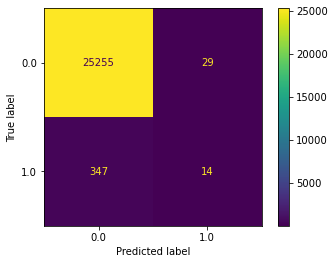

In [71]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test,sklogreg.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sklogreg.classes_)
disp.plot()
plt.show()

## ROC curve and AUC score for selected models

AUC Score for logreg 0.63
AUC Score for knn 0.5
AUC Score for gaussian 0.61
AUC Score for decision_tree 0.55
AUC Score for random_forest 0.64
AUC Score for Neural_Network 0.5
AUC Score for Adaboost 0.63


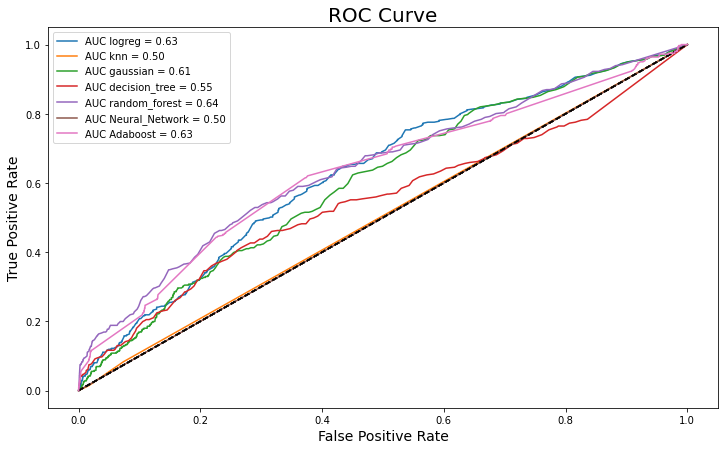

In [49]:
#Calculate and plot ROC curve and AUC Score
from sklearn.metrics        import roc_auc_score, roc_curve

plt.figure(figsize=(12, 7))
for model in models_1:
    x =  models_1[model].predict_proba(X_test)[:, 1]
    y = roc_auc_score(Y_test, x)
    fpr, tpr, thresholds = roc_curve(Y_test, x)
    print('AUC Score for', model, round(y,2)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC {model} = {y:.2f}')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()
    
# reference https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f


## Model evaluation

In [50]:
#Calculate Lift, Gain and Response for all models
lifts     = {}
cumulative_responses = {}
cumulative_gains     = {}
data      = pd.DataFrame(Y_test).copy() #validation set with targeted variable
for (index,model) in enumerate(models_1):
    data[f"proba {model}"] = pd.DataFrame(models_1[model].predict_proba(X_test))[1] #predict proba for validation set features
    lifts[model] = lift(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    cumulative_responses[model] = cumulativeResponse(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    cumulative_gains[model] = cumulativeGains(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    lifts[model]["Quantile"] = 1 - lifts[model]["Quantile"]
    cumulative_responses[model]["Quantile"] = 1 - cumulative_responses[model]["Quantile"]
    cumulative_gains[model]["Quantile"] = 1 - cumulative_gains[model]["Quantile"]
            

## Plot Lifts

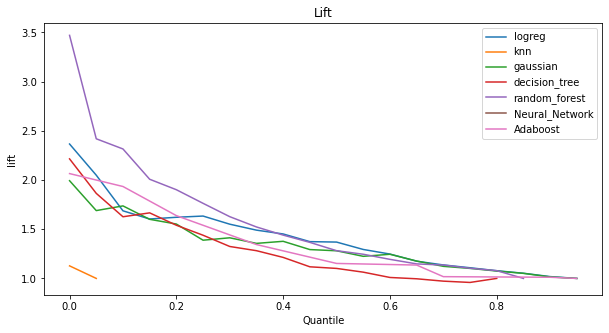

In [51]:
#Plot Lift for all Models
plt.figure(figsize=(10, 5))
for model in models_1:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"], label = model)
    #plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend()

## Plot Cumulative responses

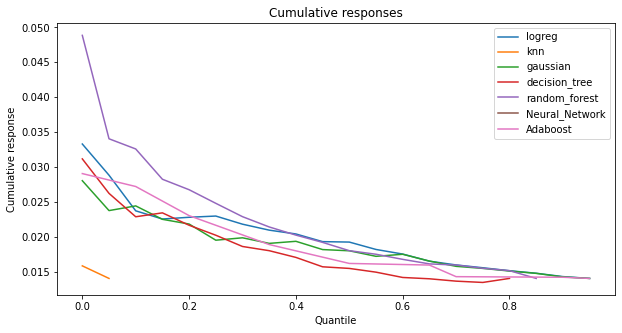

In [52]:
#Plot Cumulative Response for all Models
plt.figure(figsize=(10, 5))
for model in models_1:
    plt.plot(cumulative_responses[model]["Quantile"], cumulative_responses[model]["Cumulative response"],
            label = model)
    #plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative response")
    plt.title("Cumulative responses")
    plt.legend()

## Plot Cumulative Gains 

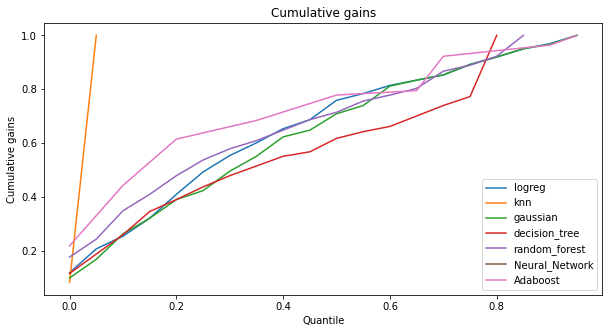

In [53]:
#Plot Cumulative Gains for all Models
plt.figure(figsize=(10, 5))
for model in models_1:
    plt.plot(cumulative_gains[model]["Quantile"], cumulative_gains[model]["Cumulative gains"], label = model)
    #plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative gains")
    plt.title("Cumulative gains")
    plt.legend()

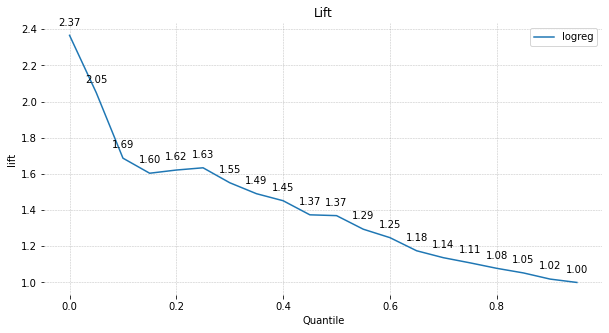

In [54]:
# plotting lifts for logreg
fig, ax = plt.subplots(figsize=(10, 5))
xs = lifts['logreg']["Quantile"]
ys = lifts['logreg']["Lift"]
plt.plot(xs,ys , label = 'logreg')
plt.xlabel("Quantile")
plt.ylabel("lift")
plt.title("Lift")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend()

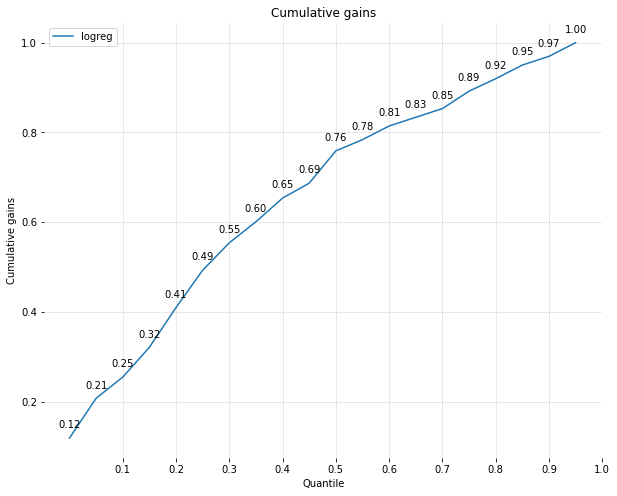

In [55]:
# plotting cumulative gains for logreg
fig, ax = plt.subplots(figsize=(10, 8))
xs = cumulative_gains["logreg"]["Quantile"]
ys = cumulative_gains["logreg"]["Cumulative gains"]
plt.plot(xs, ys, label = "logreg")
plt.xlabel("Quantile")
plt.ylabel("Cumulative gains")
plt.title("Cumulative gains")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.set_xticks(ticks=np.arange(0.1,1.1,0.1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()

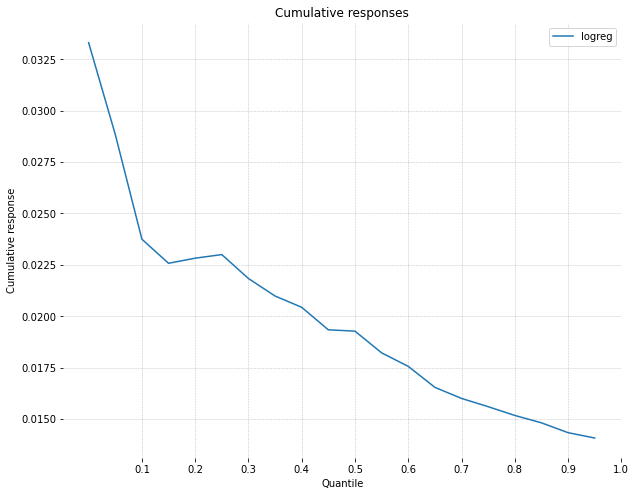

In [56]:
#plotting cumulative responses for logreg
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(cumulative_responses["logreg"]["Quantile"], cumulative_responses["logreg"]["Cumulative response"],
            label = "logreg")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks(ticks=np.arange(0.1,1.1,0.1))
plt.xlabel("Quantile")
plt.ylabel("Cumulative response")
plt.title("Cumulative responses")
plt.legend()

In [57]:
predicted_length = []
for model in models_1:
    donor_new['probability'] = pd.DataFrame(models_1[model].predict_proba(donor_new[selectedFeatures]))[1]
    donor_new['donated'] = pd.DataFrame(models_1[model].predict(donor_new[selectedFeatures]))
    length = len(donor_new[donor_new['donated'] == 1])
    a = [model,length,(length/25645)]
    predicted_length.append(a)
predicted_length = pd.DataFrame(predicted_length)

In [58]:
predicted_length

,0,1,2
0,logreg,8554,0.333554
1,knn,527,0.020550
2,gaussian,1089,0.042464
3,decision_tree,83,0.003236
4,random_forest,35,0.001365
5,Neural_Network,0,0.000000
6,Adaboost,11,0.000429


In [61]:
#Calculate the probability and target
donor_scoring_file = donor_new.copy()
donor_scoring_file['probability'] = pd.DataFrame(sklogreg.predict_proba(donor_scoring_file[selectedFeatures]))[1]
donor_scoring_file['donated'] = pd.DataFrame(sklogreg.predict(donor_scoring_file[selectedFeatures]))
donor_scoring_file

,donorID,province,region,gender,language,dateOfBirth,ANTWERP,BRUSSELS,EAST FLANDERS,FLEMISH BRABANT,...,Total_Amount,Average_Amount,Maximum_Amount,Minimum_Amount,recency,lor,donated,age,age_group,probability
0,100001,FLEMISH BRABANT,Flanders,1,NL,1967-12-24,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53,50,0.581605
1,100002,ANTWERP,Flanders,0,NL,1952-01-14,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,60,0.426045
2,100008,FLEMISH BRABANT,Flanders,0,FR,1937-08-30,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,83,80,0.528690
3,100009,BRUSSELS,Brussels,0,FR,1932-01-20,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,88,80,0.569318
4,100010,BRUSSELS,Brussels,0,FR,1983-05-30,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,30,0.232107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,FLEMISH BRABANT,Flanders,0,FR,1982-08-29,0,0,0,1,...,40.0,40.0,40.0,40.0,1239.0,1239.0,0.0,38,30,0.290572
25641,144683,EAST FLANDERS,Flanders,0,NL,1985-06-15,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,30,0.220609
25642,144686,ANTWERP,Flanders,1,NL,1964-09-28,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,56,50,0.605367
25643,144690,FLEMISH BRABANT,Flanders,0,FR,1976-05-07,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,40,0.267680


In [63]:
#Write probabilities to file
donor_scoring_file[['donorID','donated','probability']].to_csv('Group1_scoring.csv')

In [70]:
#Get cumulative responses
cumulative_responses["logreg"]

,Quantile,Cumulative response,Average response
19,0.00,0.033308,0.014077
18,0.05,0.028846,0.014077
17,0.10,0.023748,0.014077
16,0.15,0.022577,0.014077
15,0.20,0.022825,0.014077
14,0.25,0.023000,0.014077
13,0.30,0.021836,0.014077
12,0.35,0.020984,0.014077
11,0.40,0.020436,0.014077
10,0.45,0.019340,0.014077


In [65]:
#Get average donation made in 7244 campaign
gifts_7244 = gifts[gifts['campaignID'] == campaignid_test]
gifts_7244_avg = gifts_7244['amount'].mean()
gifts_7244_avg

51.56786703601108

## Profiling

In [66]:
#Filter for profiling
donor_profiling = donor_scoring_file[(donor_scoring_file['donated'] == 1) & (donor_scoring_file['Total_Amount'] > 0)]
donor_profiling.head()

,donorID,province,region,gender,language,dateOfBirth,ANTWERP,BRUSSELS,EAST FLANDERS,FLEMISH BRABANT,...,Total_Amount,Average_Amount,Maximum_Amount,Minimum_Amount,recency,lor,donated,age,age_group,probability
14,100034,BRUSSELS,Brussels,0,NL,1959-04-12,0,1,0,0,...,45.0,45.0,45.0,45.0,469.0,1825.0,1.0,61,60,0.549605
57,100132,BRUSSELS,Brussels,1,FR,1953-09-09,0,1,0,0,...,30.0,30.0,30.0,30.0,1293.0,1293.0,1.0,67,60,0.746391
75,100164,BRUSSELS,Brussels,0,NL,1953-02-25,0,1,0,0,...,39.0,39.0,39.0,39.0,1460.0,2422.0,1.0,67,60,0.539298
102,100217,WALLOON BRABANT,Wallonia,0,FR,1950-04-03,0,0,0,0,...,100.0,100.0,100.0,100.0,219.0,2416.0,1.0,70,70,0.558032
104,100220,WALLOON BRABANT,Wallonia,1,FR,1973-08-24,0,0,0,0,...,39.0,39.0,39.0,39.0,1244.0,1827.0,1.0,47,40,0.631648


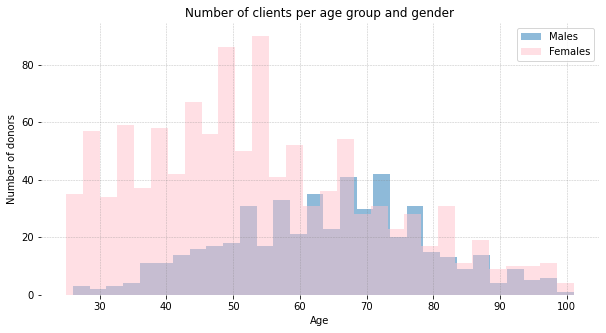

In [67]:
#Number of clients per age group and gender
fig, ax = plt.subplots(figsize = (10,5))
ax.hist(donor_profiling.loc[donor_profiling.gender == 0, 'age'], bins=30, alpha=0.5, label='Males')
ax.hist(donor_profiling.loc[donor_profiling.gender == 1, 'age'], bins=30, alpha=0.5, label='Females', color = 'pink')
ax.set_title('Number of clients per age group and gender')
ax.set_xlabel('Age')
ax.set_ylabel('Number of donors')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend()
plt.show()

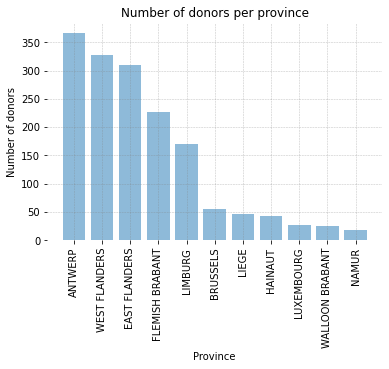

In [68]:
#Number of account orders per region
# Calculate the population per continent
num_clients_region = donor_profiling.groupby('province')['donorID'].agg(['count'])
num_clients_region = num_clients_region.sort_values(by='count', ascending=False)
# Bar plot
fig, ax = plt.subplots()
ax.bar(num_clients_region.index, num_clients_region['count'],alpha=0.5)
ax.set_title('Number of donors per province')
plt.xticks(rotation='vertical')
ax.set_xlabel('Province')
ax.set_ylabel('Number of donors')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()